# Spam Email Classification Model
First, we try the naive version in the link attached to the assignment4. Then we do some improvement on the previous version. Although the dataset we use here is from UCI machine learning Repository which is not a very large dataset, we can still assume a more generative scenario that if we have hundres or thousands gigabytes data, then we will not be able to use the traditional way to train the model and we need to apply big data technology. We will use the PySpark library for the follwoing training part.

In [1]:
import boto3

import sagemaker
import sagemaker_pyspark
from sagemaker import get_execution_role

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import udf
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,\
                                  BinaryClassificationEvaluator
from pyspark.ml.feature import Tokenizer, StopWordsRemover, \
                               HashingTF, IDF
from pyspark.ml.linalg import VectorUDT

from sagemaker_pyspark import RandomNamePolicyFactory, IAMRole,\
                              EndpointCreationPolicy, SageMakerModel,\
                              SageMakerResourceCleanup
from sagemaker_pyspark.algorithms import XGBoostSageMakerEstimator,\
                                         PCASageMakerEstimator
from sagemaker_pyspark.transformation.serializers \
     import ProtobufRequestRowSerializer
from sagemaker_pyspark.transformation.serializers.serializers \
     import LibSVMRequestRowSerializer

from sklearn.metrics import confusion_matrix, roc_curve, auc

import re
import os
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools


# Set random seed
seed = 5590

## Setup 

In [2]:
# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [4]:
# Create an S3 bucket to store training data
bucket_name = '2020-hw4-data' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [6]:
# Set up Spark Configure
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local")\
    .appName("Spam Filter")\
    .getOrCreate()
    
spark

## Download Data and Put into S3

In [38]:
!mkdir -p dataset
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip -o dataset/smsspamcollection.zip
!unzip -o dataset/smsspamcollection.zip -d dataset
!head -10 dataset/SMSSpamCollection

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198k  100  198k    0     0   269k      0 --:--:-- --:--:-- --:--:--  268k
Archive:  dataset/smsspamcollection.zip
  inflating: dataset/SMSSpamCollection  
  inflating: dataset/readme          
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat

In [39]:
!mv dataset/SMSSpamCollection SMSSpamCollection

In [40]:
# Upload into S3 bucket
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'SMSSpamCollection')).upload_file('SMSSpamCollection')

## Load Data 

In [43]:
# Define a Schema for df
schema = StructType([
    StructField("class", StringType()),
    StructField("sms", StringType())
])

file_name = 'SMSSpamCollection'
# Import CSV
df = spark.read\
          .schema(schema)\
          .option("header", "true")\
          .csv('s3a://{}/{}'.format(bucket_name, file_name), sep = '\t')

df.show()
print("The schema for dataset:")
df.printSchema()
print("The length of dataset:")
print(df.count())


+-----+--------------------+
|class|                 sms|
+-----+--------------------+
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
| spam|FreeMsg Hey there...|
|  ham|Even my brother i...|
|  ham|As per your reque...|
| spam|WINNER!! As a val...|
| spam|Had your mobile 1...|
|  ham|I'm gonna be home...|
| spam|SIX chances to wi...|
| spam|URGENT! You have ...|
|  ham|I've been searchi...|
|  ham|I HAVE A DATE ON ...|
| spam|XXXMobileMovieClu...|
|  ham|Oh k...i'm watchi...|
|  ham|Eh u remember how...|
|  ham|Fine if thats th...|
| spam|England v Macedon...|
|  ham|Is that seriously...|
+-----+--------------------+
only showing top 20 rows

The schema for dataset:
root
 |-- class: string (nullable = true)
 |-- sms: string (nullable = true)

The length of dataset:
5573


In [45]:
# Check null
df.where(reduce(lambda x, y: x | y, (f.col(x).isNull() for x in df.columns))).show()

+-----+---+
|class|sms|
+-----+---+
+-----+---+



In [48]:
df.select('class').distinct().show()

+-----+
|class|
+-----+
|  ham|
| spam|
+-----+



## Preprocess of dataset
In this part, we will try to do some transformation to the dataset so that we can train our model better<br> 
It will including three mahor steps: Text Normalization, Tokenization, TF-IDF Transformation

### Text Normalization
In order to normalize the text data, we will lowercase all texts and dealing with some special notation(number, emoticon, currency sign, links, HTML character entities, punctuation and special characters) <br>
To deal with the symbol transformation, we apply regex here.

In [51]:
# Lowercase all texts
df_norm = df.select("class","sms", f.lower(f.col("sms")).alias("sms_norm"))
df_norm.show()

+-----+--------------------+--------------------+
|class|                 sms|            sms_norm|
+-----+--------------------+--------------------+
|  ham|Ok lar... Joking ...|ok lar... joking ...|
| spam|Free entry in 2 a...|free entry in 2 a...|
|  ham|U dun say so earl...|u dun say so earl...|
|  ham|Nah I don't think...|nah i don't think...|
| spam|FreeMsg Hey there...|freemsg hey there...|
|  ham|Even my brother i...|even my brother i...|
|  ham|As per your reque...|as per your reque...|
| spam|WINNER!! As a val...|winner!! as a val...|
| spam|Had your mobile 1...|had your mobile 1...|
|  ham|I'm gonna be home...|i'm gonna be home...|
| spam|SIX chances to wi...|six chances to wi...|
| spam|URGENT! You have ...|urgent! you have ...|
|  ham|I've been searchi...|i've been searchi...|
|  ham|I HAVE A DATE ON ...|i have a date on ...|
| spam|XXXMobileMovieClu...|xxxmobilemovieclu...|
|  ham|Oh k...i'm watchi...|oh k...i'm watchi...|
|  ham|Eh u remember how...|eh u remember how...|


In [52]:
# Define the regex

html_list = ["&lt;", "&gt;", "&amp;", "&cent;", "&pound;", "&yen;", "&euro;", "&copy;", "&reg;"]

regex_url = "\\w+(\\.|-)*\\w+@.*\\.(com|de|uk)"
regex_emoticon = ":\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)"
regex_number = "\\d+"
regex_punctuation = "[\\.\\,\\:\\-\\!\\?\\n\\t,\\%\\#\\*\\|\\=\\(\\)\\\"\\>\\<\\/]"
regex_currency = "[\\$\\€\\£]"
regex_url = "(http://|https://)?www\\.\\w+?\\.(de|com|co.uk)"
regex_html = "|".join(html_list)

dict_norm = {
    regex_emoticon : " normalized_emoticon ",
    regex_url : " normalized_emailadress ",
    regex_number : " normalized_number ",
    regex_punctuation : " ",
    regex_currency : " normalized_currency_symbol ",
    regex_url: " normalized_url ",
    regex_html : " "
}


In [53]:
# Normalize the text and create a new column
for key, value in dict_norm.items():
    df_norm = df_norm.withColumn("sms_norm", f.regexp_replace(f.col("sms_norm"),key, value))

In [54]:
# Drop possible null value generated by normalization
df = df_norm.dropna()

df.show()

+-----+--------------------+--------------------+
|class|                 sms|            sms_norm|
+-----+--------------------+--------------------+
|  ham|Ok lar... Joking ...|ok lar    joking ...|
| spam|Free entry in 2 a...|free entry in  no...|
|  ham|U dun say so earl...|u dun say so earl...|
|  ham|Nah I don't think...|nah i don't think...|
| spam|FreeMsg Hey there...|freemsg hey there...|
|  ham|Even my brother i...|even my brother i...|
|  ham|As per your reque...|as per your reque...|
| spam|WINNER!! As a val...|winner   as a val...|
| spam|Had your mobile 1...|had your mobile  ...|
|  ham|I'm gonna be home...|i'm gonna be home...|
| spam|SIX chances to wi...|six chances to wi...|
| spam|URGENT! You have ...|urgent  you have ...|
|  ham|I've been searchi...|i've been searchi...|
|  ham|I HAVE A DATE ON ...|i have a date on ...|
| spam|XXXMobileMovieClu...|xxxmobilemovieclu...|
|  ham|Oh k...i'm watchi...|oh k   i'm watchi...|
|  ham|Eh u remember how...|eh u remember how...|


### Encode Class Label
Before we convert the text data in to numerical values, we first convert class label

In [59]:
df = df.withColumn("class", f.when(f.col("class") == "spam" , 1).
                             when(f.col("class") == "ham" , 0).
                             otherwise(f.col("class")))

df.show()

+-----+--------------------+--------------------+
|class|                 sms|            sms_norm|
+-----+--------------------+--------------------+
|    0|Ok lar... Joking ...|ok lar    joking ...|
|    1|Free entry in 2 a...|free entry in  no...|
|    0|U dun say so earl...|u dun say so earl...|
|    0|Nah I don't think...|nah i don't think...|
|    1|FreeMsg Hey there...|freemsg hey there...|
|    0|Even my brother i...|even my brother i...|
|    0|As per your reque...|as per your reque...|
|    1|WINNER!! As a val...|winner   as a val...|
|    1|Had your mobile 1...|had your mobile  ...|
|    0|I'm gonna be home...|i'm gonna be home...|
|    1|SIX chances to wi...|six chances to wi...|
|    1|URGENT! You have ...|urgent  you have ...|
|    0|I've been searchi...|i've been searchi...|
|    0|I HAVE A DATE ON ...|i have a date on ...|
|    1|XXXMobileMovieClu...|xxxmobilemovieclu...|
|    0|Oh k...i'm watchi...|oh k   i'm watchi...|
|    0|Eh u remember how...|eh u remember how...|


### Tokenization
In this part, we aim at converting the text into a set of numerical values <br>
However, under the large dataset scenario, if the directly tokenize the text data, the whole dataset will still keep very large. In order to improve the efficency, we need to decrease the dataset size <br> 
Inspired by my Machine Learning Class from Professor Linda <br>
We can use the TF-IDF to represent our text for each email.
When we calculate the TF-IDF, we don't want some common words(the, and, a,...) to effect our results, so we can remove these unimportant words by define stop words. <br>
At the same time, we will use a pyspark pipeline which will help us to make the code more simple. We will put the tokenizer, stop word remover and HashingTF process in it.

In [60]:
# Create pipeline
tokenizer = Tokenizer(inputCol="sms_norm", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="tokens_filtered")
hashingTF = HashingTF(inputCol="tokens", outputCol="features_tf", 
                      numFeatures=1000)

pipeline_text = Pipeline(stages=[tokenizer, remover, hashingTF])

In [62]:
# Fit the pipeline
pipeline_text_fit = pipeline_text.fit(df)
df_pipeline = pipeline_text_fit.transform(df)
df_pipeline.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|class|                 sms|            sms_norm|              tokens|     tokens_filtered|         features_tf|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Ok lar... Joking ...|ok lar    joking ...|[ok, lar, , , , j...|[ok, lar, , , , j...|(1000,[20,372,484...|
|    1|Free entry in 2 a...|free entry in  no...|[free, entry, in,...|[free, entry, , n...|(1000,[35,73,128,...|
|    0|U dun say so earl...|u dun say so earl...|[u, dun, say, so,...|[u, dun, say, ear...|(1000,[57,368,372...|
|    0|Nah I don't think...|nah i don't think...|[nah, i, don't, t...|[nah, think, goes...|(1000,[135,210,32...|
|    1|FreeMsg Hey there...|freemsg hey there...|[freemsg, hey, th...|[freemsg, hey, da...|(1000,[36,91,98,9...|
|    0|Even my brother i...|even my brother i...|[even, my, brothe...|[even, brother, l...|(1000

### Split Training Set and Data Set

In [63]:
split_train = 0.8
train, test = df_pipeline.randomSplit([split_train, (1-split_train)], seed=seed)

print("Shape - Train")
print((train.count(), len(train.columns)))
print()
print("Shape - Test")
print((test.count(), len(test.columns)))

Shape - Train
(4423, 6)

Shape - Test
(1150, 6)


### Calculate Term Frequency - Inverse Document Frequency (TF-IDF) 

In [64]:
#Initialize IDF Estimator
idf = IDF(minDocFreq=2, inputCol="features_tf", outputCol="features_tfidf")

# Train IDF Estimator to Term Frequency Data
idfModel = idf.fit(train)

# Re-Scale Term Frequency Data to 
train = idfModel.transform(train)
test = idfModel.transform(test)

#Inspect
train.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|class|                 sms|            sms_norm|              tokens|     tokens_filtered|         features_tf|      features_tfidf|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0| &lt;#&gt;  in mc...|      in mca  but...|[, , , , , , in, ...|[, , , , , , mca,...|(1000,[18,83,372,...|(1000,[18,83,372,...|
|    0| &lt;DECIMAL&gt; ...|  decimal  m but ...|[, , decimal, , m...|[, , decimal, , m...|(1000,[18,62,83,1...|(1000,[18,62,83,1...|
|    0| and  picking the...| and  picking the...|[, and, , picking...|[, , picking, var...|(1000,[128,263,33...|(1000,[128,263,33...|
|    0| came to look at ...| came to look at ...|[, came, to, look...|[, came, look, fl...|(1000,[7,146,197,...|(1000,[7,146,197,...|
|    0| gonna let me kno...| gonna let me kno...|[, gonna, let

### Select the final data column we need

In [68]:
df_train=train.select(f.col("class").alias("label"), f.col("features_tfidf").alias("features"))
df_train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(1000,[18,83,372,...|
|    0|(1000,[18,62,83,1...|
|    0|(1000,[128,263,33...|
|    0|(1000,[7,146,197,...|
|    0|(1000,[51,134,164...|
|    0|(1000,[44,133,168...|
|    0|(1000,[122,138,17...|
|    0|(1000,[281,372,49...|
|    0|(1000,[170,234,37...|
|    0|(1000,[83,141,296...|
|    0|(1000,[71,73,83,8...|
|    0|(1000,[15,76,138,...|
|    0|(1000,[47,73,76,1...|
|    0|(1000,[18,76,83,8...|
|    0|(1000,[36,71,83,1...|
|    0|(1000,[23,27,129,...|
|    0|(1000,[25,71,77,1...|
|    0|(1000,[170,296,37...|
|    0|(1000,[25,48,73,8...|
|    0|(1000,[372,597,76...|
+-----+--------------------+
only showing top 20 rows



In [69]:
df_test = test.select(f.col("class").alias("label"), f.col("features_tfidf").alias("features"))
df_test.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(1000,[73,83,183,...|
|    0|(1000,[19,42,44,8...|
|    0|(1000,[13,44,76,8...|
|    0|(1000,[82,173,329...|
|    0|(1000,[234,372,55...|
+-----+--------------------+
only showing top 5 rows



## Train With XGBoost 
API Reference: https://sagemaker-pyspark.readthedocs.io/en/latest/api.html

In [70]:
# Transform our dataframe so that in can fit into the model
new_schema = StructType([
    StructField("label", DoubleType()),
    StructField("features", VectorUDT())
])

# Train Set
df_train = df_train.withColumn("label", f.col('label').cast(DoubleType()))
df_train = df_train.withColumn("features", f.col('features').cast(VectorUDT()))
print("Schema - Train")
df_train.printSchema()

# Test Set
df_test = df_test.withColumn("label", f.col('label').cast(DoubleType()))
df_test = df_test.withColumn("features", f.col('features').cast(VectorUDT()))
print("Schema - Test")
df_test.printSchema()



Schema - Train
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)

Schema - Test
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [72]:
# Initialize Model
xgboost_estimator = XGBoostSageMakerEstimator(
  sagemakerRole = IAMRole(role),
  requestRowSerializer=LibSVMRequestRowSerializer(schema=new_schema,
                                                 featuresColumnName="features",
                                                 labelColumnName="label"),
  trainingInstanceType = "ml.m4.xlarge",
  trainingInstanceCount = 1,
  endpointInstanceType = "ml.m4.xlarge",
  endpointInitialInstanceCount = 1,
  namePolicyFactory=RandomNamePolicyFactory("spam-xgb-"),
  endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

In [73]:
# Set Hyperparameters
xgboost_estimator.setNumRound(15)
xgboost_estimator.setObjective("binary:logistic")
xgboost_estimator.setEvalMetric("auc")
xgboost_estimator.setSeed(seed)

In [74]:
# Fit the training set
model = xgboost_estimator.fit(df_train)

## Evaluate the model 

In [75]:
# Get predict results
predictions = model.transform(df_test)

# Translate the predict results
predictions = predictions.withColumn("prediction_binary", \
                                     f.when(f.col("prediction") > 0.5 , 1.0).
                                     otherwise(0.0))

predictions = predictions.withColumn("prediction_spam", \
                                     f.when(f.col("prediction_binary") == 1 ,\
                                            "spam").otherwise("ham"))

predictions = predictions.withColumn("label_spam",\
                                     f.when(f.col("label") == 1 , "spam").
                                     otherwise("ham"))
predictions.show()

+-----+--------------------+----------------+-----------------+---------------+----------+
|label|            features|      prediction|prediction_binary|prediction_spam|label_spam|
+-----+--------------------+----------------+-----------------+---------------+----------+
|  0.0|(1000,[73,83,183,...| 0.0108006848022|              0.0|            ham|       ham|
|  0.0|(1000,[19,42,44,8...|0.00748851243407|              0.0|            ham|       ham|
|  0.0|(1000,[13,44,76,8...|  0.147869259119|              0.0|            ham|       ham|
|  0.0|(1000,[82,173,329...|0.00908160861582|              0.0|            ham|       ham|
|  0.0|(1000,[234,372,55...| 0.0379120782018|              0.0|            ham|       ham|
|  0.0|(1000,[16,40,170,...|0.00748851243407|              0.0|            ham|       ham|
|  0.0|(1000,[82,159,173...|0.00748851243407|              0.0|            ham|       ham|
|  0.0|(1000,[58,146,163...|  0.224270150065|              0.0|            ham|       ham|

In [76]:
predictions.groupBy("prediction_spam").count().show()

+---------------+-----+
|prediction_spam|count|
+---------------+-----+
|            ham| 1008|
|           spam|  142|
+---------------+-----+



### Generate Confusion Matrix 

In [78]:
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [80]:
# Convert Labels to Pandas Dataframe
y_true = predictions.select("label_spam")
y_true = y_true.toPandas()

# Convert Predictions to Pandas Dataframe
y_pred = predictions.select("prediction_spam")
y_pred = y_pred.toPandas()

# Generate Raw Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels = ['ham', 'spam'])

Exception ignored in: <bound method JavaParams.__del__ of XGBoostSageMakerEstimator_47fd9be3944c37b55f26>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/py4j/java_gateway.py", line 2000, in detach
    java_object._detach()
AttributeError: 'NoneType' object has no attribute '_detach'


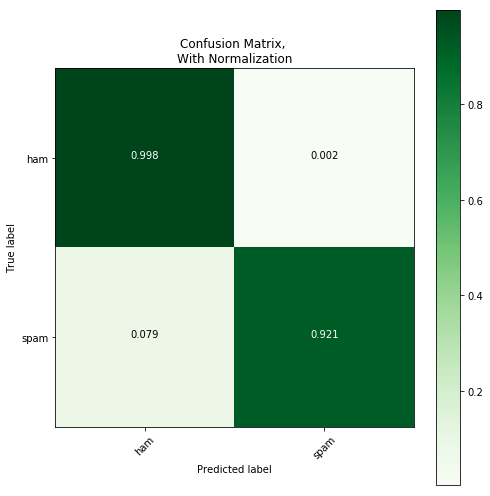

In [84]:
# Plot and visualize
plt.figure(figsize=[7,7])
show_confusion_matrix(cm, classes = ['ham', 'spam'], normalize= True, title='Confusion Matrix, \nWith Normalization')
plt.show()

### Receiver Operating Characteristic (ROC) curve

In [86]:
test_label = predictions.select('label').toPandas()
test_pred = predictions.select('prediction').toPandas()
fpr, tpr, thresholds = roc_curve(test_label, test_pred)

roc_auc = auc(fpr, tpr)

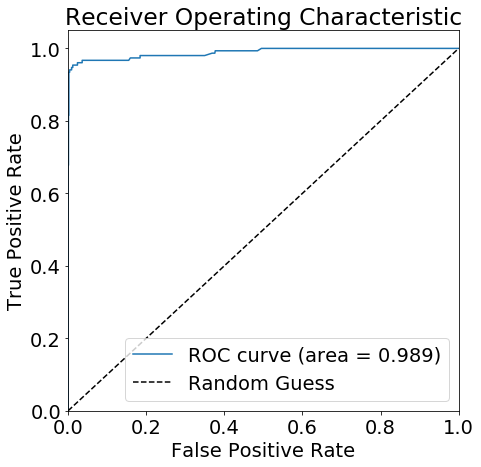

In [88]:
plt.rc('font', size=19.5) 
plt.figure(figsize=[7,7])
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

## Clean up 

In [94]:
resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
resource_cleanup.deleteResources(model.getCreatedResources())
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '197C2591B75A65D7',
   'HostId': 'otvX9FopbufkxEyLOIFN4Z8MDkFuOJlwyAwogfMiKStPgbKo97dcYZtthZhIkXxk4axR/aahcLQ=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'otvX9FopbufkxEyLOIFN4Z8MDkFuOJlwyAwogfMiKStPgbKo97dcYZtthZhIkXxk4axR/aahcLQ=',
    'x-amz-request-id': '197C2591B75A65D7',
    'date': 'Tue, 05 May 2020 01:56:55 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'spam.csv'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/SMSSpamCollection'},
   {'Key': 'SMSSpamCollection'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/spam.csv'}]}]